# 1. Import Dependencies

In [242]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Preparation

## Open initial dataset

In [243]:
df = pd.read_csv('distance_wrist_elbow.csv')

## Dataset Statistics

In [244]:
df.describe()

,class,jarak_wrist,jarak_elbow,elbow_to_wrist_ratio
count,2233.000000,2233.000000,2233.000000,2233.000000
mean,0.503807,0.108488,0.097261,1.174033
std,0.500098,0.077579,0.059334,1.213203
min,0.000000,0.001492,0.003042,0.088005
25%,0.000000,0.055240,0.052857,0.676079
50%,1.000000,0.080810,0.094994,0.816158
75%,1.000000,0.154648,0.126755,1.342841
max,1.000000,0.582473,0.409177,21.513456


## Visualization of outliers

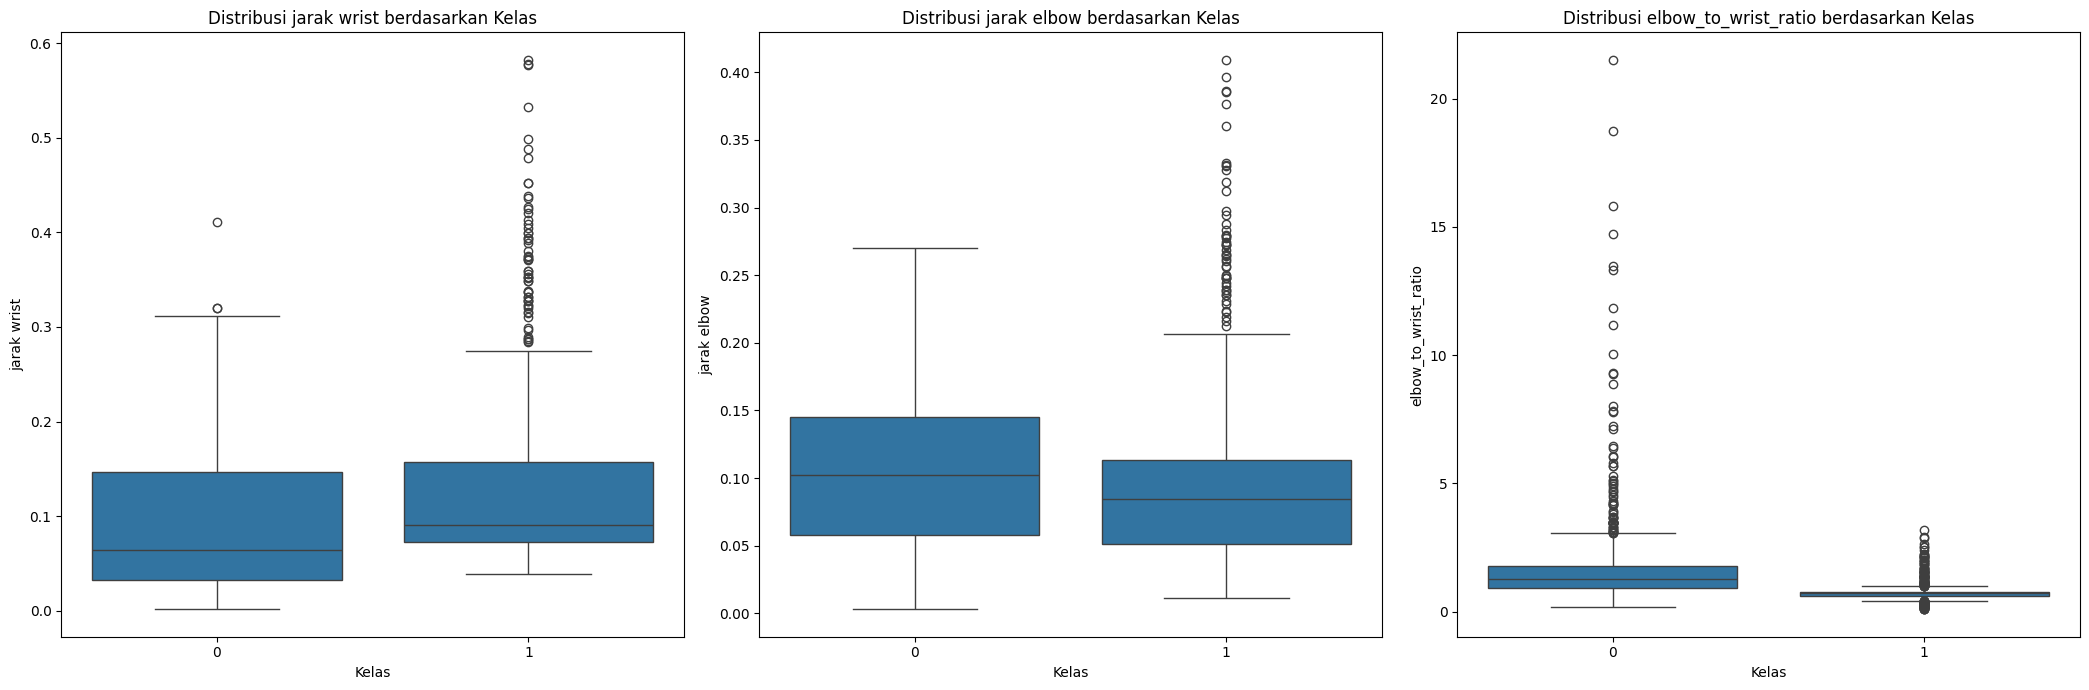

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat ukuran plot
plt.figure(figsize=(21, 7))

# Plot boxplot untuk jarak wrist
plt.subplot(1, 3, 1)
sns.boxplot(x='class', y='jarak_wrist', data=df)
plt.title('Distribusi jarak wrist berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('jarak wrist')

# Plot boxplot untuk jarak elbow
plt.subplot(1, 3, 2)
sns.boxplot(x='class', y='jarak_elbow', data=df)
plt.title('Distribusi jarak elbow berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('jarak elbow')

# Plot boxplot untuk elbow_to_wrist_ratio
plt.subplot(1, 3, 3)
sns.boxplot(x='class', y='elbow_to_wrist_ratio', data=df)
plt.title('Distribusi elbow_to_wrist_ratio berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('elbow_to_wrist_ratio')

# Tampilkan plot
plt.tight_layout()
plt.show()

## Check Outliers

In [246]:
import pandas as pd

def hapus_outliers(df, kolom):
    """
    Fungsi untuk menghapus outliers dalam sebuah kolom dataframe menggunakan metode IQR.
    
    Args:
    df : DataFrame
        DataFrame yang berisi data.
    kolom : str
        Nama kolom yang ingin diperiksa dan dihapus outliers-nya.
    
    Returns:
    DataFrame
        DataFrame tanpa outliers pada kolom yang diberikan.
    """
    Q1 = df[kolom].quantile(0.25)
    Q3 = df[kolom].quantile(0.75)
    IQR = Q3 - Q1
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas = Q3 + 1.5 * IQR

    df_bersih = df[(df[kolom] >= batas_bawah) & (df[kolom] <= batas_atas)]
    return df_bersih


## Open Cleaned Dataset

In [247]:
df = pd.read_csv('data_distance_cleaned.csv')

In [248]:
df[df['class'] == 0].shape

(938, 4)

In [249]:
df[df['class'] == 1].shape

(1066, 4)

## Shuffle Dataset

In [250]:
df = df.sample(frac=1).reset_index(drop=True)

## Split Dataset

In [251]:
X = df.drop('class', axis=1)
y = df['class']

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [253]:
print(f'Ukuran X_train: {X_train.shape}')
print(f'Ukuran X_test: {X_test.shape}')
print(f'Ukuran y_train: {y_train.shape}')
print(f'Ukuran y_test: {y_test.shape}')

Ukuran X_train: (1603, 3)
Ukuran X_test: (401, 3)
Ukuran y_train: (1603,)
Ukuran y_test: (401,)


## Setup GPU for training

In [254]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 3. Modelling

In [255]:
model = tf.keras.Sequential([
    layers.Dense(32, input_dim=3, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])


In [256]:
model.compile(optimizer ='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [257]:
class ThresholdAccuracy(tf.keras.callbacks.Callback):
        def __init__(self, threshold=0.80):
            super(ThresholdAccuracy, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy is not None and val_accuracy is not None:
                if accuracy > self.threshold and val_accuracy > self.threshold:
                    print(f"\nEpoch {epoch+1}: accuracy telah mencapai {accuracy:.2%} dan val_accuracy mencapai {val_accuracy:.2%}, lebih besar dari threshold {self.threshold:.2%}. Berhenti training.")
                    self.model.stop_training = True

callback = ThresholdAccuracy(threshold=0.9)

Epoch 1/100
33/33 [==============================] - 1s 14ms/step - loss: 0.6549 - accuracy: 0.6856 - val_loss: 0.5743 - val_accuracy: 0.8454
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 0.5324 - accuracy: 0.8091 - val_loss: 0.4327 - val_accuracy: 0.8354
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4750 - accuracy: 0.8041 - val_loss: 0.4048 - val_accuracy: 0.8454
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4694 - accuracy: 0.8147 - val_loss: 0.4052 - val_accuracy: 0.8554
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 0.4615 - accuracy: 0.8122 - val_loss: 0.3976 - val_accuracy: 0.8529
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4617 - accuracy: 0.8122 - val_loss: 0.3933 - val_accuracy: 0.8479
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.4523 - accuracy: 0.8129 - val_loss: 0.3879 - val_accuracy: 0.8504
Epoch 8/1

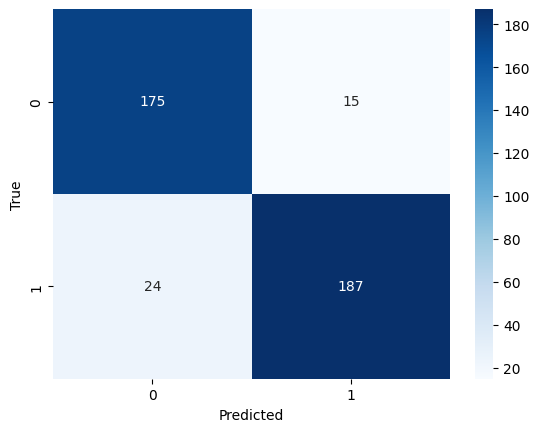

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       190
           1       0.93      0.89      0.91       211

    accuracy                           0.90       401
   macro avg       0.90      0.90      0.90       401
weighted avg       0.90      0.90      0.90       401



In [258]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), callbacks=[callback])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

## Convert Model

In [259]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_elbow_position.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpqvlp_pf2\assets


# 4. Testing

## Function to calculate distance

In [260]:
def hitung_jarak(a, b):
    a = np.array(a)
    b = np.array(b)
    jarak = np.linalg.norm(a - b) # Menghitung jarak Euclidean antara dua titik
    return jarak

## Testing model through video stream

In [268]:
import time

mp_drawing = mp.solutions.drawing_utils 
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture('test7.mp4')

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (640, 480))
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        results = pose.process(image)
    
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            wrist_left = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].z]
            elbow_left = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].z]
            shoulder_left = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].z]

            wrist_right = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].z]
            elbow_right = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].z]
            shoulder_right = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].z]
            
            jarak_wrist = hitung_jarak(wrist_left, wrist_right)
            jarak_elbow = hitung_jarak(elbow_left, elbow_right)

            elbow_to_wrist_ratio = jarak_elbow / jarak_wrist
            print(jarak_wrist, jarak_elbow)
            print(elbow_to_wrist_ratio)

            row = [jarak_wrist, jarak_elbow, elbow_to_wrist_ratio]
            row = np.expand_dims(row, axis=0)  # Add a batch dimension
            prediction = model.predict(row)
            print(f'Result: {prediction[0][0]}')
                
            if prediction[0][0] > 0.6:
                current_stage = 'Correct'
            elif prediction[0][0] <= 0.6:
                current_stage = 'Wrong'

            cv2.rectangle(image, (0, 0), (250, 60), (245, 117, 16), -1)

            cv2.putText(image, 'CLASS', (95, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, current_stage, (95, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            cv2.putText(image, 'PROB', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(prediction[0][0], 2)), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        

            if elbow_to_wrist_ratio > 1.3:  # threshold can be adjusted
                current_stage = f'Siku keluar {round(elbow_to_wrist_ratio, 2)}'
            else:
                current_stage = f'Siku benar {round(elbow_to_wrist_ratio, 2)}'
            
            position = (int(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x * 640), 
                        int(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y * 480))
            cv2.putText(image, current_stage, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                       
        except Exception as e:
            print(f"Error: {e}")
        
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        time.sleep(0.2)
    cap.release()
    cv2.destroyAllWindows()

0.6960440457235395 0.6419968799424283
0.9223509401263119
Result: 1.0
0.8329831551246362 0.6680271286065323
0.8019695530416554
Result: 1.0
0.8541211514945409 0.6924409625461634
0.8107057896113805
Result: 1.0
0.8454625166644192 0.6936922943825041
0.8204885263504169
Result: 1.0
0.8419877932794073 0.6892924485669205
0.8186489805062815
Result: 1.0
0.7934344913047723 0.6687348514399657
0.8428356200399824
Result: 1.0
0.7559794218258694 0.650698292514688
0.8607354561888702
Result: 1.0
0.7634832629010115 0.649908222787275
0.8512409562428588
Result: 1.0
0.7790520014588127 0.6521154834477075
0.8370628433359899
Result: 1.0
0.7903411388113661 0.6543156732770478
0.8278901870920019
Result: 1.0
0.8121124736077652 0.659359134962204
0.811906178503868
Result: 1.0
0.845863171905236 0.6785979135398047
0.8022549462832383
Result: 1.0
0.9030995450545113 0.7062161825463715
0.7819915162328469
Result: 1.0
0.9072957268918461 0.7127070698920192
0.7855289612501142
Result: 1.0
0.9064801023018221 0.7148783075235975
0